# End-to-End AutoML for Life Insurance Assessment

## Part 1 - EDA and Data Pre-Processing


### Contents
[Part 1 - Project Overview](#overview)  
[Part 2 - Initial Setup](#setup)  
[Part 3 - Exploratory Data Analysis](#eda)  
[Part 4 - Data Pre-Processing and Transformation](#pre-processing)  
[Part 5 - References](#references) 

___
<a name="overview"></a>
## (1) Project Overview

**The Challenge**  
In a one-click shopping world with on-demand everything, the life insurance application process is antiquated. Customers provide extensive information to identify risk classification and eligibility, including scheduling medical exams, a process that takes an average of 30 days.

The result? People are turned off. That’s why only 40% of U.S. households own individual life insurance. Prudential wants to make it quicker and less labor intensive for new and existing customers to get a quote while maintaining privacy boundaries.

By developing a predictive model that accurately classifies risk using a more automated approach, you can greatly impact public perception of the industry.

The results will help Prudential (one of the largest issuers of life insurance in USA) better understand the predictive power of the data points in the existing assessment, enabling us to significantly streamline the process.

Link: https://www.kaggle.com/c/prudential-life-insurance-assessment/overview 
___
**The Data**  
In this dataset, you are provided over a hundred variables describing attributes of life insurance applicants. The task is to predict the "Response" variable for each Id in the test set. 

*Response* is an ordinal measure of risk that has 8 levels.  

*Variable and Description*  
**Id**: A unique identifier associated with an application.  
**Product_Info_1-7:** A set of normalized variables relating to the product applied for  
**Ins_Age:** Normalized age of applicant  
**Ht:** Normalized height of applicant  
**Wt:** Normalized weight of applicant  
**BMI:** Normalized BMI of applicant  
**Employment_Info_1-6:** A set of normalized variables relating to the employment history of the applicant.  
**InsuredInfo_1-6:** A set of normalized variables providing information about the applicant.  
**Insurance_History_1-9:** A set of normalized variables relating to the insurance history of the applicant.  
**Family_Hist_1-5:** A set of normalized variables relating to the family history of the applicant.  
**Medical_History_1-41:** A set of normalized variables relating to the medical history of the applicant.  
**Medical_Keyword_1-48:** A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application.  
**Response:** This is the target variable, an ordinal variable relating to the final decision associated with an application (ranges 1 - 8)

___
<a name="setup"></a>
## (2) Initial Setup

### Import dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

import opendatasets as od
import zipfile

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

### Download and Import Datasets
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials.

In [2]:
# Retrieve data directly from source (using Kaggle API credentials, found in kaggle.json)
od.download("https://www.kaggle.com/c/prudential-life-insurance-assessment/data?select=train.csv.zip",
           './data/raw')

Skipping, found downloaded files in "./data/raw\prudential-life-insurance-assessment" (use force=True to force download)


In [3]:
# View files in the raw folder
raw_path = './data/raw/prudential-life-insurance-assessment/'
os.listdir(raw_path)

<IPython.core.display.Javascript object>

['sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip']

In [ ]:
# Unzip and store the CSV files in another folder (input folder)
for filename in os.listdir(raw_path):
    with zipfile.ZipFile(raw_path+filename, 'r') as zip_ref:
        zip_ref.extractall('./data/input/')

In [3]:
# Import input datasets
main_df = pd.read_csv('data/input/train.csv')
test_df = pd.read_csv('data/input/test.csv')

### Setup helper functions

In [4]:
# Display value counts and NaN counts
def show_value_counts(df, column):
    value_count_df = pd.DataFrame(df[column].value_counts().rename_axis(column).reset_index(name='counts'))
    value_count_df['percentage'] = round(100 * (value_count_df['counts'] / len(df)),1)
    return value_count_df

def show_nan_counts(df):
    nan_count_df = pd.DataFrame(df.isna().sum()).sort_values(by=0, ascending = False)
    nan_count_df.columns = ['counts']
    nan_count_df['percentage'] = round(100 * (nan_count_df['counts'] / len(df)),1)
    return nan_count_df

# Display correlation plot as heatmap
def show_heatmap(data, figsize=(12,8), 
                 highest_only=False, 
                 thresold=0.7, # Look at only highly correlated pairs
                 annot=False):
    correlation_matrix = data.corr()
    high_corr = correlation_matrix[np.abs(correlation_matrix )>= thresold]
    plt.figure(figsize=figsize)

    if highest_only:
        sns.heatmap(high_corr, annot=annot, cmap="Greens", 
                    linecolor='black', linewidths=0.1)
    else:
        sns.heatmap(correlation_matrix, annot=annot)

___
<a name="eda"></a>
## (3) Exploratory Data Analysis (EDA)
- Broadly speaking, the features can be grouped based on the following:
    - Basic Info
    - Product Info
    - Medical History
    - Medical keywords

In [7]:
main_df.shape

(59381, 128)

In [8]:
main_df.sample(10)

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
10936,14519,1,A8,26,0.025641,2,3,1,0.492537,0.618182,0.246862,0.488220,0.025,9,1,0.0,2,0.20,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,NaN,NaN,NaN,NaN,7.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
48194,64183,2,D3,26,1.000000,2,1,1,0.208955,0.781818,0.267782,0.363297,0.450,9,1,0.0,2,0.15,1,2,3,3,1,1,1,2,1,3,1,0.000033,1,3,2,3,0.405797,NaN,0.323944,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
57632,76793,2,A1,26,1.000000,2,3,1,0.298507,0.781818,0.351464,0.491491,0.600,9,1,0.0,2,1.00,2,2,2,2,1,1,1,2,1,1,3,NaN,3,2,3,2,0.376812,NaN,0.422535,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6
14518,19330,1,A3,26,0.179487,2,3,1,0.432836,0.709091,0.242678,0.386163,0.050,14,1,0.0,2,0.10,2,2,6,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.652174,NaN,0.563380,NaN,5.0,112,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
50263,66941,1,D4,26,0.128205,2,3,1,0.089552,0.563636,0.152720,0.349196,0.006,9,1,0.0,2,NaN,1,2,2,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.202899,NaN,0.140845,NaN,0.0,569,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
32199,42720,1,D4,26,0.487179,2,3,1,0.34328

___
### Response (target) variable

In [9]:
show_value_counts(main_df, 'Response')

,Response,counts,percentage
0,8,19489,32.8
1,6,11233,18.9
2,7,8027,13.5
3,2,6552,11.0
4,1,6207,10.5
5,5,5432,9.1
6,4,1428,2.4
7,3,1013,1.7


<AxesSubplot:xlabel='Response', ylabel='count'>

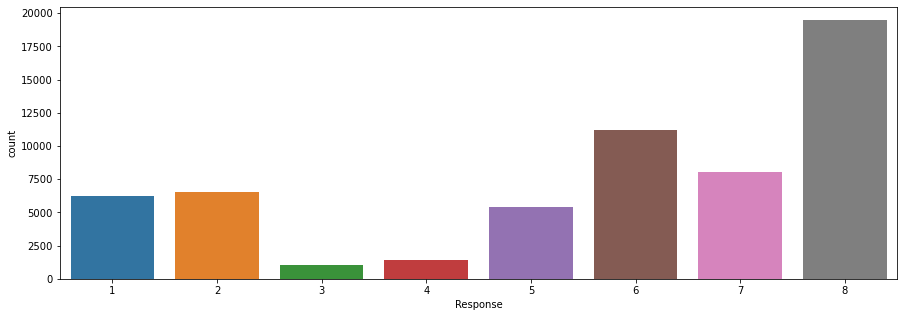

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.countplot(x=main_df["Response"], order=[1,2,3,4,5,6,7,8], ax=ax)

### Predictor Variables

In [11]:
main_df.dtypes

Id                       int64
Product_Info_1           int64
Product_Info_2          object
Product_Info_3           int64
Product_Info_4         float64
Product_Info_5           int64
Product_Info_6           int64
Product_Info_7           int64
Ins_Age                float64
Ht                     float64
Wt                     float64
BMI                    float64
Employment_Info_1      float64
Employment_Info_2        int64
Employment_Info_3        int64
Employment_Info_4      float64
Employment_Info_5        int64
Employment_Info_6      float64
InsuredInfo_1            int64
InsuredInfo_2            int64
InsuredInfo_3            int64
InsuredInfo_4            int64
InsuredInfo_5            int64
InsuredInfo_6            int64
InsuredInfo_7            int64
Insurance_History_1      int64
Insurance_History_2      int64
Insurance_History_3      int64
Insurance_History_4      int64
Insurance_History_5    float64
Insurance_History_7      int64
Insurance_History_8      int64
Insuranc

In [12]:
# Identify columns which are not numerical:
categorical = [col for col in main_df.columns if main_df[col].dtype =='object']
categorical

['Product_Info_2']

In [13]:
show_value_counts(main_df, 'Product_Info_2')

,Product_Info_2,counts,percentage
0,D3,14321,24.1
1,D4,10812,18.2
2,A8,6835,11.5
3,D1,6554,11.0
4,D2,6286,10.6
5,E1,2647,4.5
6,A1,2363,4.0
7,A6,2098,3.5
8,A2,1974,3.3
9,A7,1383,2.3


In [14]:
show_nan_counts(main_df)

,counts,percentage
Medical_History_10,58824,99.1
Medical_History_32,58274,98.1
Medical_History_24,55580,93.6
Medical_History_15,44596,75.1
Family_Hist_5,41811,70.4
Family_Hist_3,34241,57.7
Family_Hist_2,28656,48.3
Insurance_History_5,25396,42.8
Family_Hist_4,19184,32.3
Employment_Info_6,10854,18.3


___
#### Correlation Plot for Basic Columns

In [15]:
# Get list of basic columns (excludes medical and product related info)
basic_cols = (main_df.columns[~main_df.columns.str.startswith('Medical') & ~main_df.columns.str.startswith('Product')]).tolist()

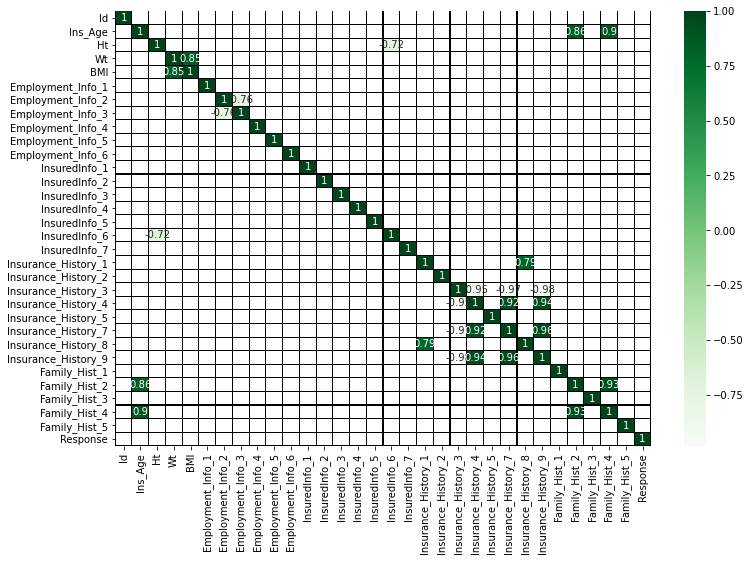

In [16]:
# Display plot for only basic columns
show_heatmap(main_df[basic_cols], highest_only=True, annot=True)

___
<a name="pre-processing"></a>
## (4) Data Pre-Processing and Transformation

#### (i) Drop columns with >50% NaN values

In [17]:
def drop_high_nan_cols(df, threshold):
    nan_counts_top = show_nan_counts(df).loc[show_nan_counts(df)['percentage'] > threshold]
    df.drop(columns = nan_counts_top.index.values.tolist(), inplace=True)
    return df

In [19]:
main_df = drop_high_nan_cols(main_df, 50)

predictor_cols = [col for col in main_df.columns.tolist() if col != 'Response']

# Match columns with main df
test_df = test_df[predictor_cols]

___
#### (ii) Split Product_Info_2 into separate alphabet and number
- Since Product_Info_2 is non-numerical, with values coming in categories such as A1, D4 etc.

In [20]:
def split_product_info_2(df):
    df['Product_Info_2_Alpha'] = df['Product_Info_2'].str[0]
    df['Product_Info_2_Num'] = df['Product_Info_2'].str[1].astype('int64')
    return df

In [21]:
main_df = split_product_info_2(main_df)
test_df = split_product_info_2(test_df)

___
#### (iii) LabelEncode the new non-numerical Product_Info_2 related columns

In [22]:
def label_encode(train, test):
    train_categorical = [col for col in train.columns if train[col].dtype =='object']
    
    for col in train_categorical:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])
        
    return train, test

In [23]:
main_df, test_df = label_encode(main_df, test_df)

___
#### (iv) Create count of presence of medical keywords
- Almost like a proxy for how many medical conditions the person has

In [24]:
def gen_medical_keyword_count(df):
    med_keyword_cols = df.columns[df.columns.str.startswith('Medical_Keyword_')]
    df['Med_Keywords_Count'] = df[med_keyword_cols].sum(axis=1)
    return df

In [25]:
main_df = gen_medical_keyword_count(main_df)
test_df = gen_medical_keyword_count(test_df)

___
#### (v) Drop unnecessary columns

In [26]:
# test_df.drop(columns = ['BMI'], inplace=True) # BMI already highly correlated with weight

In [27]:
main_df.drop(columns = ['Id'], inplace=True)
main_df.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_Alpha,Product_Info_2_Num,Med_Keywords_Count
0,1,16,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,NaN,4.0,112,2,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,1,3,3,1,3,2,3,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,3,0
1,1,0,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,0.084507,5.0,412,2,1,1,3,2,2,1,3,2,3,3,1,3,1,1,2,1,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0
2,1,18,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,0.225352,10.0,3,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,1,0
3,1,17,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,0.352113,0.0,350,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,2,2,3,1,3,3,1,3,2,3,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,4,1
4,1,15,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,0.408451,NaN,162,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2,0


___
### Export processed datasets

In [28]:
main_df.to_csv('data/processed/train.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)